# 数据读取，和预处理

In [5]:
import os
import cv2
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path = 'train/'
datas = pd.read_csv(path+'train_label.csv')

In [ ]:
datas.head(n=5)

### 读取csv

In [ ]:
class CSVDataReader:
    def __init__(self,csv_path,batch_size):
        self.batch_size = batch_size
        # 构造文件名路径队列
        self.file_path_queue = tf.train.string_input_producer([csv_path])
    def get(self):
        reader = tf.TextLineReader()
        #从文件路径中读取文件名，并取出文件的每一行
        _, value = reader.read(self.file_path_queue)
        # 设置每一行的默认值
        record_defaults = [[''], ['']]
        # 解析csv文件的每一行
        img_path_tf, img_label_tf = tf.decode_csv(value, record_defaults)
        tensors = [[img_path_tf,img_label_tf]]
        img_path_batch,img_label_batch = tf.train.shuffle_batch_join(tensors,
                                                                     batch_size=self.batch_size,
                                                                     capacity = 100,
                                                                     min_after_dequeue=20,
                                                                    enqueue_many=False)
        
#         img_path_batch,img_label_batch = tf.train.batch_join(tensors,
#                                                              batch_size=self.batch_size,
#                                                              capacity = 100,
#                                                             enqueue_many=False)
        
        return img_path_batch,img_label_batch

              
    

In [ ]:
#从datasets/csv_data.csv文件中读取数据，设置BatchSize为6
dataReader=CSVDataReader('train/train_label.csv',4)
img_path_batch,img_label_batch =dataReader.get()

In [ ]:
with tf.Session() as sess: 
    coord = tf.train.Coordinator()
    #启动所有队列线程，使得每个队列源源不断执行入队和出队
    threads = tf.train.start_queue_runners(coord=coord)

    img_path_batchs,img_label_batchs = sess.run([img_path_batch,img_label_batch])
    for img_path_batchs_v,img_label_batchs_v in zip(img_path_batchs,img_label_batchs):
        print(img_path_batchs_v.decode(),img_label_batchs_v.decode())

    coord.request_stop()
    coord.join(threads)  

###  读取和生成tfrecord

In [3]:
import tensorflow as tf
import cv2
# 图片的长度和宽度
width = 120
height = 40
# 每个验证码所包含的字符数
word_len = 4 

In [ ]:
class TFRecordWriter:
    def __init__(self,tfrecord_path,path):
        self.tfrecord_path=tfrecord_path
        self.path = path
    def write(self):
        writer = tf.python_io.TFRecordWriter(self.tfrecord_path)  # 要生成的文件 
        def get_labels(img_label):
            labels = ['0','1','2','3','4','5','6','7','8','9',
                       'A','B','C','D','E','F','G','H','I','J',
                       'K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                       'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
                       'q','r','s','t','u','v','w','x','y','z'
                       ]
            label2id = {} # 标签转id
            id2label = {} # id转标签

            for label in labels:
                label2id[label] = len(label2id)
            for label, id in label2id.items():
                id2label[id] = label
            l1, l2, l3, l4 = tuple(img_label[:4]) # 切分出验证码的四位标签
            labels1 = label2id[l1]
            labels2 = label2id[l2]
            labels3 = label2id[l3]
            labels4 = label2id[l4]
            label1s = tf.keras.utils.to_categorical(labels1, num_classes=62)
            label2s = tf.keras.utils.to_categorical(labels2, num_classes=62)
            label3s = tf.keras.utils.to_categorical(labels3, num_classes=62)
            label4s = tf.keras.utils.to_categorical(labels4, num_classes=62)
            return np.array(label1s).astype(int), np.array(label2s).astype(int), np.array(label3s).astype(int), np.array(label4s).astype(int)
        data_list = pd.read_csv(self.path+'train_label.csv',header=None)
        for item in data_list[1:].values:  #遍历图片
            img_path = self.path + item[0]
            labels1, labels2, labels3, labels4 = get_labels(item[1])
            img = cv2.imread(img_path)    
            img_bytes=img.tostring()
            example=tf.train.Example(features=tf.train.Features(feature={
                'label1': tf.train.Feature(int64_list=tf.train.Int64List(value=labels1)),
                'label2': tf.train.Feature(int64_list=tf.train.Int64List(value=labels2)),
                'label3': tf.train.Feature(int64_list=tf.train.Int64List(value=labels3)),
                'label4': tf.train.Feature(int64_list=tf.train.Int64List(value=labels4)),
                'img': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes]))
            }))

            writer.write(example.SerializeToString())  # 序列化为字符串并写入文件
        writer.close()
writer=TFRecordWriter('img_label_data.tfrecords',path)
writer.write()

(4, 40, 120, 3)


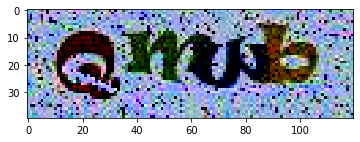

In [29]:
class TFRecordReader:
    def __init__(self,tfrecord_path,batch_size):
        self.batch_size=batch_size
        self.tfrecord_path=tfrecord_path
    def get(self):
       # 根据文件名生成一个队列
        file_path_queue = tf.train.string_input_producer([self.tfrecord_path]) 
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(file_path_queue) 
        features = tf.parse_single_example(serialized_example,
                                           features={
                                               'label1': tf.FixedLenFeature([62], tf.int64),
                                               'label2': tf.FixedLenFeature([62], tf.int64),
                                               'label3': tf.FixedLenFeature([62], tf.int64),
                                               'label4': tf.FixedLenFeature([62], tf.int64),
                                               'img': tf.FixedLenFeature([], tf.string),})
        # 读取label
        label1 = tf.cast(features['label1'], tf.int64)  
        label2 = tf.cast(features['label2'], tf.int64)  
        label3 = tf.cast(features['label3'], tf.int64)  
        label4 = tf.cast(features['label4'], tf.int64)  
        
        
        img = tf.decode_raw(features['img'], tf.uint8)
        #将维度指定为256*256的3通道
        img = tf.reshape(img, [height,width, 3])
         
        #img = tf.image.random_saturation(img, 2.0, 10.0)    
        img = tf.image.random_contrast(img, 0.0, 20.0)   
        img_batch,label_batch1,label_batch2,label_batch3,label_batch4,=tf.train.shuffle_batch_join([[img,label1,label2,label3,label4,]],
                                                  batch_size=self.batch_size,
                                                  capacity=100,
                                                  min_after_dequeue=20,
                                                  enqueue_many=False)     
        return img_batch,label_batch1,label_batch2,label_batch3,label_batch4,  
        
        

#从6_5_1_datasets.tfrecords文件中读取数据，设置BatchSize为6
dataReader=TFRecordReader('img_label_data.tfrecords',4)
img_batch,label_batch1,label_batch2,label_batch3,label_batch4,=dataReader.get()



with tf.Session() as sess: 
    coord = tf.train.Coordinator()
    #启动所有队列线程，使得每个队列源源不断执行入队和出队
    threads = tf.train.start_queue_runners(coord=coord)
    imgs,labels1,labels2,labels3,labels4 = sess.run([img_batch,label_batch1,label_batch2,label_batch3,label_batch4]) 
    print(imgs.shape)
    plt.figure(figsize=[6,2]) 
    plt.imshow(imgs[2,:,:,:])
    
    coord.request_stop()
    coord.join(threads)    
    

In [ ]:
class YZDataReader:
    def __init__(self,path,batch_size,hw_root,img_size =(120,40)):
        self.hw_root = hw_root
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = self.path
    def get_img_and_label(self):
        kvs = tf.read_file(self.path+'train_label.csv')
        
        
        

# 模型一构建

In [ ]:
import tensorflow as tf

def conv(in_tensor, layer_name, k, s, out_c, is_training=True,with_bias=False,use_bn=True,relu=tf.nn.relu6 ):
 


    with tf.variable_scope(layer_name):
        in_size = in_tensor.get_shape().as_list() 
        ss = [1, s, s, 1]
        kernel_shape = [k, k, in_size[3], out_c] 
        # conv
        kernel = tf.get_variable('weights', kernel_shape, tf.float32,
                                 tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])

        
        x = tf.nn.conv2d(in_tensor , kernel , ss, padding='SAME') 
        print(x)
        
        
        # bias
        if with_bias:
            biases = tf.get_variable('biases', [kernel_shape[3]], tf.float32,
                                    tf.constant_initializer(0.0001), trainable=is_training, collections=['wd', 'variables', 'biases']) 
            x = tf.nn.bias_add(x, biases, name='bias')
        
        
        if use_bn:
            x=batch_norm(x,is_training=is_training)
            
            
        if not relu is None:
            x=relu(x,"Relu6")
        return x
    

    
    
    
def batch_norm(in_tensor, is_training):  
    return tf.contrib.layers.batch_norm(in_tensor,
                                        center=True,
                                        decay=0.9997,
                                        scale=True,
                                        epsilon=0.001,
                                        activation_fn=None,
                                        #updates_collections=None,
                                        is_training=is_training) 
def max_pool(in_tensor, name='max_pool'):
    pooled = tf.nn.max_pool(in_tensor, ksize=[1, 2, 2, 1], ss=[1, 2, 2, 1],
                            padding='VALID', name=name)
    print(pooled)
    return pooled

def global_pool(input_tensor, pool_op=tf.nn.avg_pool):
    """Applies avg pool to produce 1x1 output.
    NOTE: This function is funcitonally equivalenet to reduce_mean, but it has
    baked in average pool which has better support across hardware.
    Args:
    input_tensor: input tensor
    pool_op: pooling op (avg pool is default)
    Returns:
    a tensor batch_size x 1 x 1 x depth.
    """
    shape = input_tensor.get_shape().as_list()
    if shape[1] is None or shape[2] is None:
        k = tf.convert_to_tensor(
            [1, tf.shape(input_tensor)[1],
             tf.shape(input_tensor)[2], 1])
    else:
        k = [1, shape[1], shape[2], 1]
        output = pool_op(
          input_tensor, ksize=k, strides=[1, 1, 1, 1], padding='VALID')
        # Recover output shape, for unknown shape.
        output.set_shape([None, 1, 1, None])
    return output
#Depthwise+Pointwise
def DepthSepConv(in_tensor, layer_name, k, s, out_c, is_training=True,relu=tf.nn.relu6):
    with tf.variable_scope(layer_name+'_depthwise'):
        in_size = in_tensor.get_shape().as_list() 
        #depwise conv
        ss = [1, s, s, 1]
        #dw_kernel_shape=[filter_height, filter_width, in_channels, channel_multiplier]
        dw_kernel_shape = [k, k, in_size[3], 1] 
        dw_kernel = tf.get_variable('depthwise_weights', dw_kernel_shape, tf.float32,
                                 tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])
       
        x=tf.nn.depthwise_conv2d( in_tensor, dw_kernel, ss, padding='SAME',  name= layer_name+'_depthwise') 
        x=batch_norm(x,is_training=is_training)
        x=relu(x,"Relu6")
        print(x)
    with tf.variable_scope(layer_name+'_pointwise'):    
        #pointwise conv
        pw_kernel_shape = [1, 1, in_size[3], out_c] 
        pw_kernel = tf.get_variable('weights', pw_kernel_shape, tf.float32, tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])
        
        x = tf.nn.conv2d(x, pw_kernel, [1,1,1,1], padding='SAME') 
        x=batch_norm(x,is_training=is_training)
        x=relu(x,"Relu6")
        print(x)
        return x
"""
MobileNet_V2中的Block实现，
代码参考自https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet_v2.py
"""
def make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
#mobile net V2
def expanded_conv(in_tensor, layer_name, k, s, out_c,expand_rate, is_training=True,relu=tf.nn.relu6 ):
    in_size = in_tensor.get_shape().as_list() 
    expansion_size = make_divisible(in_size[3] * expand_rate, 8)
    x=in_tensor
    if expansion_size>in_size[3]:
        with tf.variable_scope(layer_name+'_expand'):   
            #pointwise conv
            pw_kernel_shape = [1, 1, in_size[3], expansion_size] 
            pw_kernel = tf.get_variable('weights', pw_kernel_shape, tf.float32, tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])
            
            x = tf.nn.conv2d(in_tensor, pw_kernel, [1,1,1,1], padding='SAME') 
            x=batch_norm(x,is_training=is_training)
            x=relu(x,"Relu6")
            print(x) 
    with tf.variable_scope(layer_name+'_depthwise'):
       
        #depwise conv
        ss = [1, s, s, 1]
        #dw_kernel_shape=[filter_height, filter_width, in_channels, channel_multiplier]
        dw_kernel_shape = [k, k, x.get_shape().as_list()[3], 1] 
        dw_kernel = tf.get_variable('depthwise_weights', dw_kernel_shape, tf.float32,
                                 tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])
        
        x=tf.nn.depthwise_conv2d( x, dw_kernel, ss, padding='SAME',  name= layer_name+'_depthwise') 
        x=batch_norm(x,is_training=is_training)
        x=relu(x,"Relu6")
        print(x)
    
    with tf.variable_scope(layer_name+'_project'):    
        #pointwise conv
        pw_kernel_shape = [1, 1, x.get_shape().as_list()[3], out_c] 
        pw_kernel = tf.get_variable('weights', pw_kernel_shape, tf.float32, tf.contrib.layers.xavier_initializer_conv2d(), trainable=is_training, collections=['wd', 'variables', 'filters'])
        
        x = tf.nn.conv2d(x, pw_kernel, [1,1,1,1], padding='SAME') 
        x=batch_norm(x,is_training=is_training) 
        print(x)
    if s==1 and out_c==in_size[3]:
        return in_tensor + x
    return x 